# Generative Adverserial Networks in PyTorch

深度神经网络主要用于监督学习：分类或回归。然而，生成对抗网络或GANs将神经网络用于一个非常不同的目的：生成建模。
> 生成建模是机器学习中的一项无监督学习任务，它涉及自动发现和学习输入数据中的规律或模式，以便模型可以用于生成或输出新的示例，这些示例可能是从原始数据集中抽取的。

在本教程中，我们将训练一个GAN来生成类似于MNIST数据库中手写数字的图像。

## Load the Data

我们首先通过使用`torchvision.datasets`中的`MNIST`辅助类，将数据下载并导入为PyTorch数据集。

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



请注意，我们将像素值的范围从`[0, 1]`转换为`[-1, 1]`。做这个的原因在定义生成器网络时会变得清楚。让我们来看一下数据中的一个样本张量。

In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

正如预期的那样，像素值的范围从-1到1。让我们定义一个辅助函数来反归一化并查看图像。这个函数也将对查看生成的图像非常有用。

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


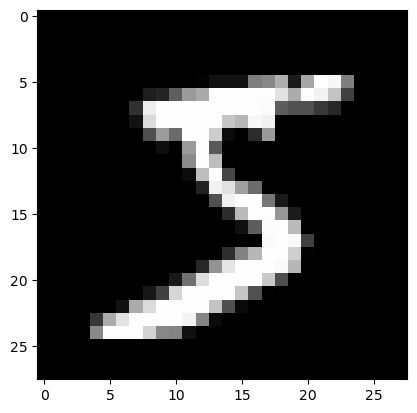

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

最后，让我们创建一个数据加载器来批量加载图像。

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 1, 1, 4, 2, 1, 2, 9, 1, 5, 4, 2, 1, 4, 3, 9, 5, 6, 5, 4, 5, 0, 2, 5,
        0, 6, 7, 8, 9, 3, 7, 1, 6, 9, 2, 9, 1, 8, 0, 6, 4, 2, 4, 1, 0, 8, 8, 8,
        1, 2, 8, 0, 8, 9, 6, 7, 2, 9, 0, 4, 4, 8, 2, 7, 0, 1, 3, 6, 6, 5, 1, 9,
        1, 3, 0, 4, 9, 3, 7, 1, 7, 6, 8, 0, 0, 3, 2, 7, 1, 7, 6, 7, 2, 5, 9, 2,
        0, 2, 7, 0])


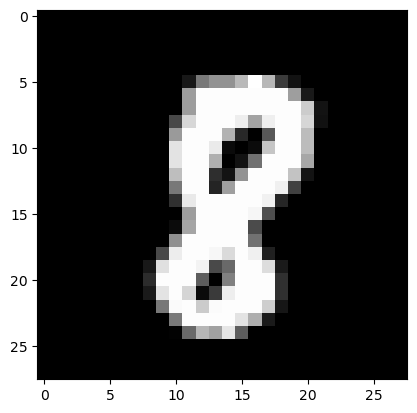

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

我们还将创建一个`device`，可以用来将数据和模型移到GPU上，如果GPU可用的话。

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cpu')

## 鉴别器网络

鉴别器接收图像作为输入，并试图将其分类为“真实”或“生成的”。在这个意义上，它就像任何其他神经网络一样。虽然我们可以使用CNN来实现鉴别器，但我们将使用一个简单的前馈网络，其中包含3个线性层来简化问题。我们将把每个28x28的图像视为大小为784的向量。

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

我们在鉴别器中使用Leaky ReLU激活函数。

> 与常规的ReLU函数不同，Leaky ReLU允许负值通过一个小的梯度信号。因此，它使来自鉴别器的梯度更强地流向生成器。在反向传播过程中，它不是传递梯度（斜率）为0，而是传递一个小的负梯度。

就像任何其他二分类模型一样，鉴别器的输出是一个介于0和1之间的单个数字，可以解释为输入图像是假的，即生成的概率。

让我们将鉴别器模型移动到所选择的设备上。

In [11]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## 生成器网络

生成器的输入通常是一个向量或矩阵，它被用作生成图像的种子。再次强调简单起见，我们将使用一个具有3层的前馈神经网络，输出将是一个大小为784的向量，可以将其转换为一个28x28像素的图像。

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

我们在生成器的输出层使用TanH激活函数。



> "在生成器中使用ReLU激活函数（Nair＆Hinton，2010），但输出层使用Tanh函数。我们观察到，使用有界激活函数可以使模型更快地学会饱和和覆盖训练分布的颜色空间。在鉴别器中，我们发现Leaky ReLU激活函数（Maas等人，2013）（Xu等人，2015）特别有效，尤其是对于更高分辨率的建模。" 

请注意，由于TanH激活函数的输出位于`[-1,1]`的范围内，我们已经将相同的转换应用于训练数据集中的图像。让我们使用生成器生成一个输出向量，并通过转换和反归一化输出来查看它。

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

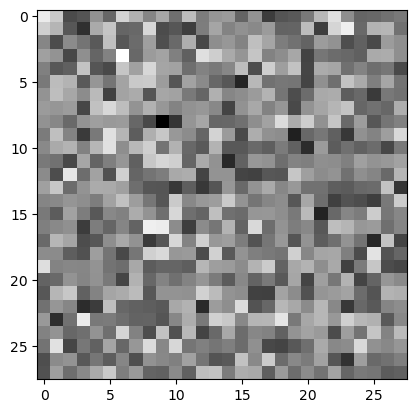

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

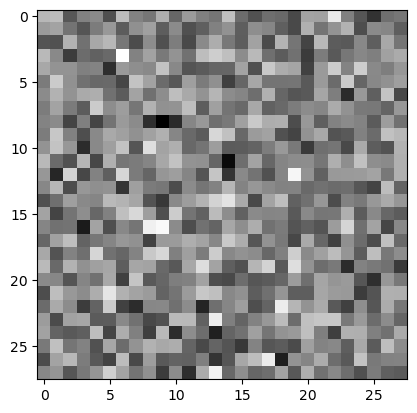

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

正如人们可能期望的那样，生成器的输出基本上是随机噪声。让我们定义一个辅助函数，可以将生成器的一个批次输出保存到文件中。

让我们将生成器移动到所选择的设备上。

In [17]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## 鉴别器训练

由于鉴别器是一个二元分类模型，我们可以使用二元交叉熵损失函数来量化它在区分真实图像和生成图像方面的表现。

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

让我们定义重置梯度和训练鉴别器的辅助函数。

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

训练鉴别器涉及以下步骤：

- 我们期望鉴别器输出1，如果图像来自真实的MNIST数据集，输出0，如果它是生成的。

- 我们首先传递一批真实图像，并计算损失，将目标标签设置为1。

- 然后，我们使用生成器生成一批假图像，将它们传递到鉴别器中，并计算损失，将目标标签设置为0。

- 最后，我们将这两个损失相加，并使用总损失执行梯度下降来调整鉴别器的权重。

重要的是要注意，在训练鉴别器时我们不改变生成器模型的权重（`d_optimizer`仅影响`D.parameters()`）。

## 生成器训练

由于生成器的输出是图像，我们不太明确如何训练生成器。这就是我们采用一种相当巧妙的技巧的地方，即将鉴别器作为损失函数的一部分。下面是它的工作原理：

- 我们使用生成器生成一批图像，将它们传递到鉴别器中。

- 我们通过将目标标签设置为1（真实）来计算损失。我们这样做是因为生成器的目标是“欺骗”鉴别器。

- 我们使用损失进行梯度下降，即改变生成器的权重，使其更好地生成类似真实的图像。

下面是代码示例。

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## 训练模型

让我们创建一个目录，可以在其中保存从生成器产生的中间输出，以便视觉检查模型的进展。

In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

让我们保存一批真实图像，以便在查看生成的图像时进行视觉比较。

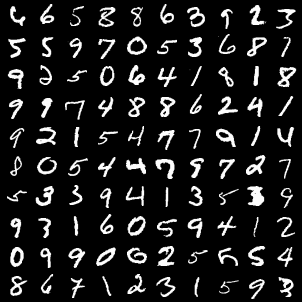

In [26]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

我们还将定义一个辅助函数，在每个时期结束时将一批生成的图像保存到磁盘上。我们将使用一组固定的输入向量传递给生成器，以查看随着我们训练模型，单个生成的图像是如何随时间演变的。

Saving fake_images-0000.png


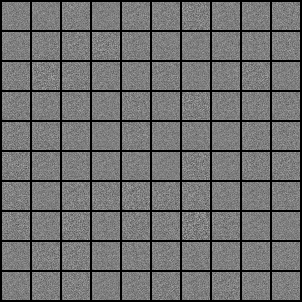

In [27]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

我们现在准备训练模型了。在每个时期中，我们首先训练鉴别器，然后训练生成器。如果您没有使用GPU，训练可能需要一段时间。

In [28]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0487, g_loss: 4.1750, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0440, g_loss: 6.0865, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0521, g_loss: 4.8570, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0522, g_loss: 6.1235, D(x): 0.98, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.3179, g_loss: 5.3366, D(x): 0.89, D(G(z)): 0.15
Epoch [1/300], Step [600/600], d_loss: 0.1652, g_loss: 4.8549, D(x): 0.94, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.5302, g_loss: 2.9670, D(x): 0.85, D(G(z)): 0.21
Epoch [2/300], Step [400/600], d_loss: 0.4647, g_loss: 2.0266, D(x): 0.86, D(G(z)): 0.20
Epoch [2/300], Step [600/600], d_loss: 0.5649, g_loss: 3.9503, D(x): 0.93, D(G(z)): 0.23
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.7836, g_loss: 2.5032, D(x): 0.75, D(G(z)): 0.21
Epoch [3/300], Step [400/6

现在我们已经训练了模型，我们可以保存检查点。

In [29]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

以下是在训练的第10、50、100和300个时期后生成的图像的样子。

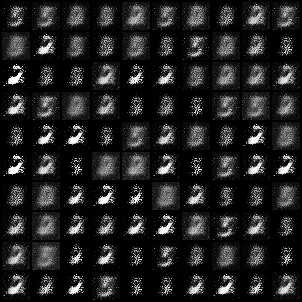

In [30]:
Image('./samples/fake_images-0010.png')

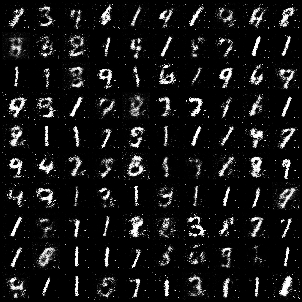

In [31]:
Image('./samples/fake_images-0050.png')

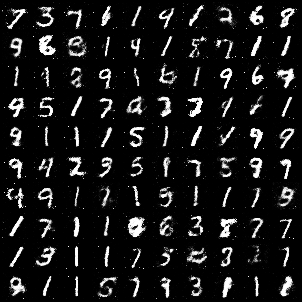

In [32]:
Image('./samples/fake_images-0100.png')

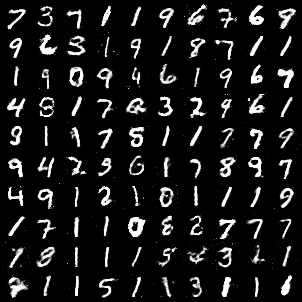

In [33]:
Image('./samples/fake_images-0300.png')

我们可以使用OpenCV将每个时期后生成的样本图像组合成视频，从而可视化训练过程。

我们还可以可视化随时间变化的损失。可视化损失对于调试训练过程非常有用。对于GANs，我们期望生成器的损失随时间降低，而鉴别器的损失不会过高。

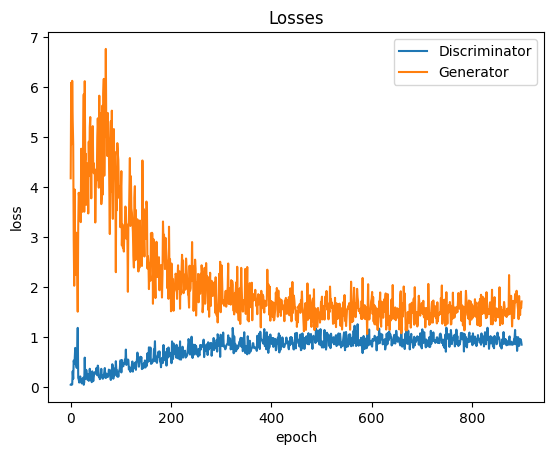

In [34]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

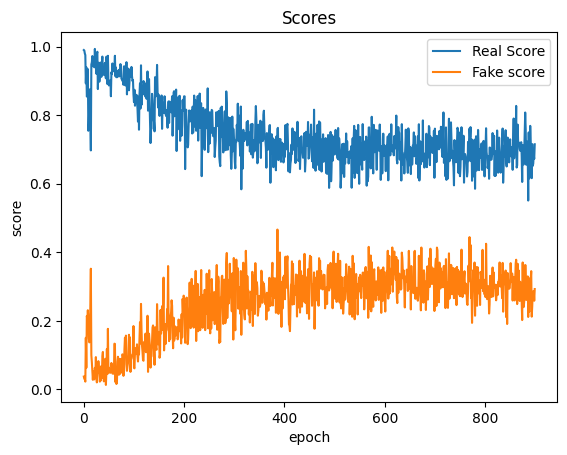

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## 作业
请大家参考上述代码，使用动漫脸数据集，它由超过63,000个裁剪的动漫脸组成。请注意，生成建模是一项无监督学习任务，因此图像没有任何标签。利用生成对抗网络生成新的图像；

![alt text](https://i.imgur.com/NaKtJs0.png)

注意：

1，数据集联系助教【程骏 QQ：7879883】
2，大家可以参考[这个项目实现](https://jovian.com/outlink?url=https%3A%2F%2Fwww.kaggle.com%2Fsplcher%2Fstarter-anime-face-dataset)